# Gesture Recognition
In this group project, we are going to build one 3D Conv and RNN+CNN3D  model that will be able to classify 5 kinds of gesture for controlling a smart TV with hand signs. Such as left swipe(reverting frames) , right swipe(forwarding frames) , stop(pausing the current frame ) , thumb down(lowering volume ) , thumb up(upping volume).
<BR><B> Group facilitator -: Sanket bhabe , group member-: Deba shankar pati</B>


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
!unzip '/content/drive/MyDrive/Project_data.zip'


Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

#### Importing necessary libraries 

In [1]:
import numpy as np
import os
from skimage.io import imread
from skimage import transform
import datetime
import os
import matplotlib.pyplot as plt
from math import floor
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM ,GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D,Conv2D,MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.utils import plot_model

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

<B>To not make the model biased towards folder structure of the dataset we randomly suffeled the folders  and also set a batch size as for batching we know all the image may not be fit in to the main memory at once .</B>

In [8]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 50

#### Writing a Generator function for yielding batches for training on a sample of data at a time 
In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. we have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[i for i in range(15,30)] #create a list of image numbers you want to use for a particular video
    while True:
       # print('number of folders'+str(len(folder_list)))
        t = np.random.permutation(folder_list)
        num_batches = floor(len(folder_list)/batch_size)
       # print('number of batches'+str(num_batches))
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,256,256,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    height=image.shape[0]
                    width=image.shape[1]
                    #top cropping
                    image=image[:,:(height//2)+75,:]
                    #resize all cropped images to 256*256 dim
                    image=transform.resize(image,(256,256))
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]-image[:,:,0].min())/(image[:,:,0].max()-image[:,:,0].min()) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =(image[:,:,1]-image[:,:,1].min())/(image[:,:,1].max()-image[:,:,1].min())#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]-image[:,:,2].min())/(image[:,:,2].max()-image[:,:,2].min()) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #print('Normal batches')
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

       # print('full batches exhausted...')
        # write the code for the remaining data points which are left after full batches
        remaining_seq= len(folder_list)-(batch_size*num_batches)
       # print('remaining sequence'+str(remaining_seq))
        batch_data = np.zeros((remaining_seq,15,256,256,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((remaining_seq,5)) # batch_labels is the one hot representation of the output
        if(remaining_seq!=0):
            for folder in range((batch_size*num_batches),len(folder_list)): # iterate over the batch_size
                #print('successfull execution')
                imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder
                #as remaining folder index starts from (batch_size*num_batches) we will subtract the folder index for 
                #making batch
                #by subtracting (batch_size*num_batches) from the folder index
                reset_index=folder-(batch_size*num_batches)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                          #crop the images and resize them. Note that the images are of 2 different shape
                    height =image.shape[0]
                    width =image.shape[1]
    #                      #top cropping
                    image=image[:,:(height//2)+75,:]
    #                      #resize all cropped images to 256*256 dim
                    image=transform.resize(image,(256,256))

    #                      #and the conv3D will throw error if the inputs in a batch have different shapes


                    batch_data[reset_index,idx,:,:,0] =(image[:,:,0]-image[:,:,0].min())/(image[:,:,0].max()-image[:,:,0].min()) #normalise and feed in the image
                    batch_data[reset_index,idx,:,:,1] =(image[:,:,1]-image[:,:,1].min())/(image[:,:,1].max()-image[:,:,1].min())#normalise and feed in the image
                    batch_data[reset_index,idx,:,:,2] =(image[:,:,2]-image[:,:,2].min())/(image[:,:,2].max()-image[:,:,2].min()) #normalise and feed in the image

                batch_labels[reset_index, int(t[folder].strip().split(';')[2])] = 1
               # print('remaining folders')
            yield batch_data, batch_labels

#### A video is represented above in the generator as (number of images, height, width, number of channels). We will take this into consideration while creating the model architecture.

### Setting up the training and validation path and number of epochs

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## CNN3D model experimentation
We will experiment with convolution 3D models using different functionalities that Keras provides , to classify the videos. 

### Exprimentation 1

In [2]:
#write your model here
model=Sequential()
model.add(Conv3D(8,kernel_size=(3,3,3),activation='relu',padding='same',input_shape=(15,256,256,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())
model.add(Conv3D(16,kernel_size=(3,3,3),activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(5,activation='softmax'))


Now that we have written the model, the next step is to `compile` the model. 

In [ ]:
optimiser = 'Adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 256, 256, 8)   656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 128, 128, 8)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 128, 128, 8)   32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 128, 128, 16)   3472      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 64, 64, 16)    0         
 3D)                                                             
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, we'll  save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 6.1534 - categorical_accuracy: 0.2504Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-05-13--12_25_07.267269/model-00001-6.15343-0.25038-1.61070-0.25000.h5
21/21 [==============================] - 200s 10s/step - loss: 6.1534 - categorical_accuracy: 0.2504 - val_loss: 1.6107 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.6330 - categorical_accuracy: 0.1961
Epoch 2: saving model to model_init_2022-05-13--12_25_07.267269/model-00002-1.63300-0.19608-1.99702-0.21000.h5
21/21 [==============================] - 181s 9s/step - loss: 1.6330 - categorical_accuracy: 0.1961 - val_loss: 1.9970 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.5992 - categorical_accuracy: 0.2112
Epoch

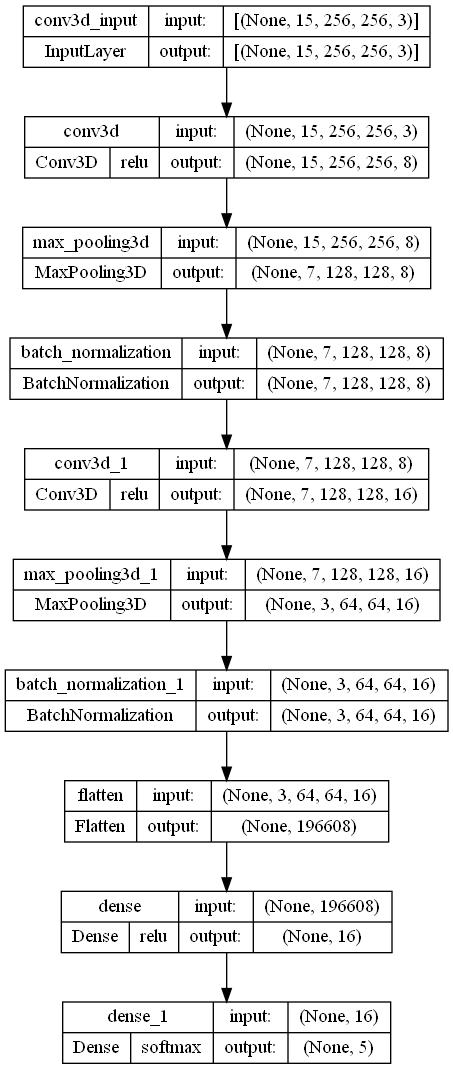

In [5]:
plot_model(model,'Experiment1.jpg',show_layer_names=True,show_shapes=True,show_layer_activations=True)

#### From above model we can see the categorical accuracy of the model on training data on last epoch is very low (approx.0.2172). 
#### To increase the model accuracy let us introduce some more hidden ( Conv3d , Maxpool3d )layers into our network.

## Experimentation 2

In [4]:
model_2=Sequential()
model_2.add(Conv3D(8,kernel_size=(3,3,3),activation='relu',padding='same',input_shape=(15,256,256,3)))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))
model_2.add(BatchNormalization())
model_2.add(Conv3D(16,kernel_size=(3,3,3),activation='relu',padding='same'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))
model_2.add(BatchNormalization())
model_2.add(Conv3D(16,kernel_size=(3,3,3),activation='relu',padding='same'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))
model_2.add(BatchNormalization())
model_2.add(Conv3D(16,kernel_size=(3,3,3),activation='relu',padding='same'))
model_2.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(16,activation='relu'))
model_2.add(Dense(5,activation='softmax'))

In [ ]:
model_2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 15, 256, 256, 8)   656       
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 7, 128, 128, 8)   0         
 3D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 7, 128, 128, 8)   32        
 hNormalization)                                                 
                                                                 
 conv3d_3 (Conv3D)           (None, 7, 128, 128, 16)   3472      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 64, 64, 16)    0         
 3D)                                                             
                                                      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
num_epochs=20

In [ ]:
history=model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.3342 - categorical_accuracy: 0.4404
Epoch 1: saving model to model_init_2022-05-13--12_25_07.267269/model-00001-1.33424-0.44042-1.55601-0.28000.h5
21/21 [==============================] - 186s 9s/step - loss: 1.3342 - categorical_accuracy: 0.4404 - val_loss: 1.5560 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 0.7921 - categorical_accuracy: 0.7014
Epoch 2: saving model to model_init_2022-05-13--12_25_07.267269/model-00002-0.79209-0.70136-1.84002-0.15000.h5
21/21 [==============================] - 187s 9s/step - loss: 0.7921 - categorical_accuracy: 0.7014 - val_loss: 1.8400 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 0.4459 - categorical_accuracy: 0.8612
Epoch 3: saving model to model_init_2022-05-13--12_25_07.267269/model-00003-0.44587-0.86124-2.14042-0.22000.h5
21/21 [========

In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

range(0, 25)
[0.44042232632637024, 0.7013574838638306, 0.8612368106842041, 0.930618405342102, 0.9668174982070923, 0.9773755669593811, 0.9849170446395874, 0.993966817855835, 0.9954751133918762, 0.9954751133918762, 0.9984917044639587, 0.9984917044639587, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


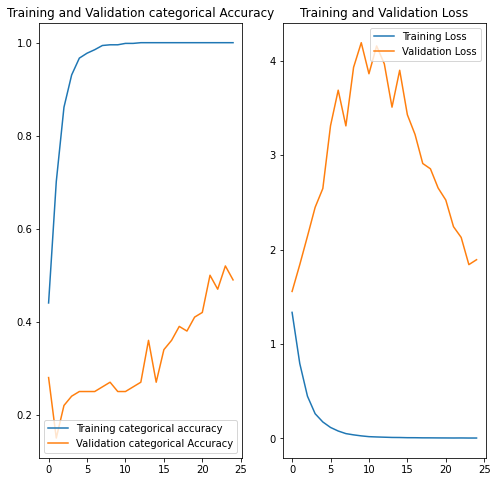

In [ ]:
#import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)
print(epochs_range)
print(acc)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training categorical accuracy')
plt.plot(epochs_range, val_acc, label='Validation categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

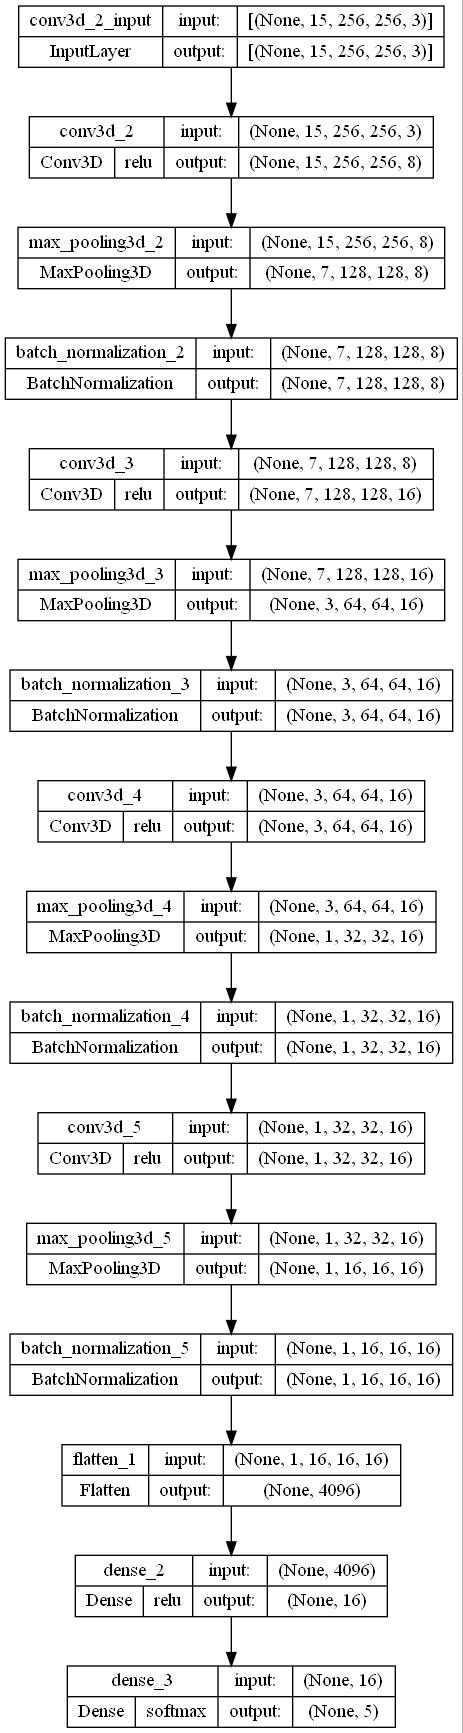

In [6]:
plot_model(model_2,'Experiment2.jpg',show_layer_names=True,show_shapes=True,show_layer_activations=True)

#### The Convolution 3D model with extra 2 conv3d and 2 maxpool3d layer is overfitting the training data as evident from the above plots .  

### Let's examine what might be the causation of overfitting  

#### Is it class imbalance problem ?


In [ ]:
import pandas as pd
gesture={'0':0,'1':0,'2':0,'3':0,'4':0}
for i in train_doc:
    classlabel=i.strip().split(';')[2]
    gesture[classlabel] +=1

In [ ]:
gesture

{'0': 136, '1': 137, '2': 130, '3': 137, '4': 123}

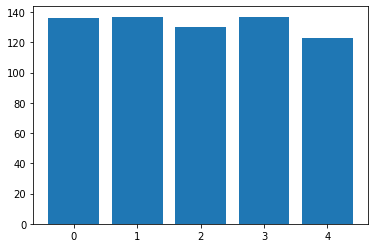

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(len(gesture)),list(gesture.values()),tick_label=list(gesture.keys()))
plt.show()

#### We can clearly see the distribution of the classes are pretty much equal so there is no class imbalance problem in training data.

#### Then our model might be learning lot of noise , hence not able to generalize the validation data , let's use dropout layers in our model to unlearn some weights , which may help in reducing learning the unneccessary noise.

## Experimentation 3

In [7]:
model_3=Sequential()

model_3.add(Conv3D(8, (2, 2, 2), padding='same',
                 input_shape=(15, 256, 256, 3)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Conv3D(16, (2, 2, 2)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Dropout(0.1))

model_3.add(Conv3D(16, (2, 2, 2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Conv3D(32, (2, 2, 2)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Dropout(0.1))

model_3.add(Conv3D(32, (2, 2, 2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Conv3D(32, (2, 2, 2)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Flatten())
model_3.add(Dense(256))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(256))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))


model_3.add(Dense(5))
model_3.add(Activation('softmax'))

In [ ]:
model_3.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 256, 256, 8)   200       
                                                                 
 activation (Activation)     (None, 15, 256, 256, 8)   0         
                                                                 
 batch_normalization_6 (Batc  (None, 15, 256, 256, 8)  32        
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 14, 255, 255, 16)  1040      
                                                                 
 activation_1 (Activation)   (None, 14, 255, 255, 16)  0         
                                                                 
 batch_normalization_7 (Batc  (None, 14, 255, 255, 16)  64       
 hNormalization)                                      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
num_epochs=20

In [ ]:
history_3=model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 50
Epoch 1/20


ResourceExhaustedError: ignored

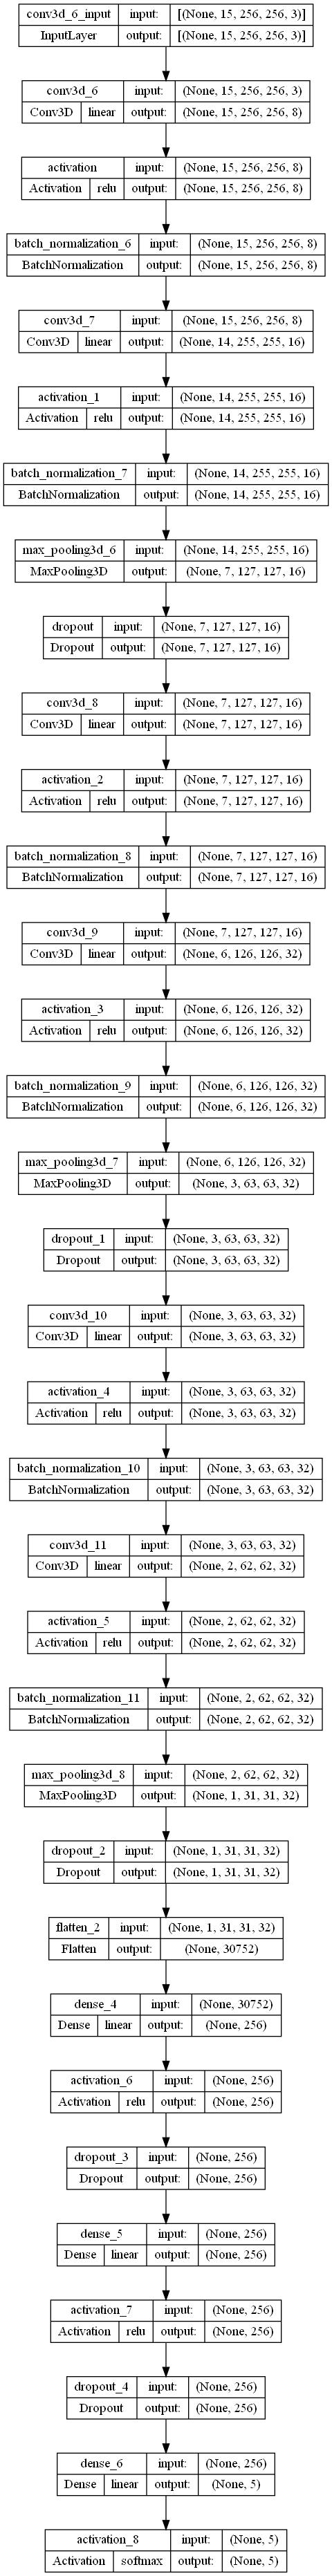

In [8]:
plot_model(model_3,'Experiment3.jpg',show_layer_names=True,show_shapes=True,show_layer_activations=True)

#### We saw in above experimentation we got an out of memory exception , which might be caused by choosing a higher batch size , let's lessen the batch size to 32.

### Experimentation 4

In [ ]:
batch_size=32 # reduce batch size to 32
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [ ]:
model_4=Sequential()
model_4.add(Conv3D(8, (2, 2, 2), padding='same',
                 input_shape=(15, 256, 256, 3)))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(Conv3D(16, (2, 2, 2)))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.1))

model_4.add(Conv3D(16, (2, 2, 2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(Conv3D(32, (2, 2, 2)))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.1))

model_4.add(Conv3D(32, (2, 2, 2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(Conv3D(32, (2, 2, 2)))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.2))

model_4.add(Flatten())
model_4.add(Dense(256))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))

model_4.add(Dense(256))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))


model_4.add(Dense(5))
model_4.add(Activation('softmax'))

In [ ]:
model_4.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 256, 256, 8)   200       
                                                                 
 activation_9 (Activation)   (None, 15, 256, 256, 8)   0         
                                                                 
 batch_normalization_12 (Bat  (None, 15, 256, 256, 8)  32        
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 14, 255, 255, 16)  1040      
                                                                 
 activation_10 (Activation)  (None, 14, 255, 255, 16)  0         
                                                                 
 batch_normalization_13 (Bat  (None, 14, 255, 255, 16)  64       
 chNormalization)                                     

In [ ]:
history_4=model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 15.3487 - categorical_accuracy: 0.2715Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-05-1308_07_00.126217/model-00001-15.34869-0.27149-6.53802-0.17000.h5
21/21 [==============================] - 248s 11s/step - loss: 15.3487 - categorical_accuracy: 0.2715 - val_loss: 6.5380 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 4.2458 - categorical_accuracy: 0.3288
Epoch 2: saving model to model_init_2022-05-1308_07_00.126217/model-00002-4.24583-0.32881-7.10816-0.22000.h5
21/21 [==============================] - 203s 10s/step - loss: 4.2458 - categorical_accuracy: 0.3288 - val_loss: 7.1082 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 2.2766 - categorical_accuracy: 0.3469
Epoch

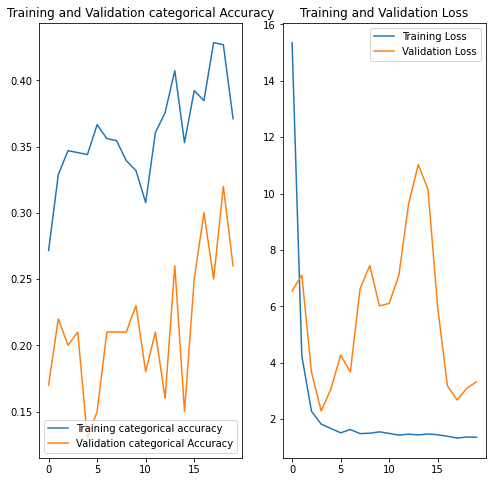

In [ ]:

acc = history_4.history['categorical_accuracy']
val_acc = history_4.history['val_categorical_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training categorical accuracy')
plt.plot(epochs_range, val_acc, label='Validation categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### By adding more layers we overfitted the model on training set and then tried to regularize the model using drop out layer , even though the accuracy on validation data increased a little , in comparision to unregularized model , still we can see the overfitting is not resolved.

#### It seems the model is unable to learn the sequential dipendencies from the sequence properly hence we will try to create a conv2D+RNN network in future experimentation. 

### Experimentation 5

In [ ]:
model_5=Sequential()
model_5.add(TimeDistributed(Conv2D(8,kernel_size=(3,3),input_shape=(15,256,256,3))))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model_5.add(TimeDistributed(BatchNormalization()))

model_5.add(TimeDistributed(Conv2D(16,kernel_size=(3,3))))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(tf.keras.layers.Dropout(0.25)))

model_5.add(TimeDistributed(Conv2D(8,kernel_size=(3,3),input_shape=(15,256,256,3))))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model_5.add(TimeDistributed(BatchNormalization()))

model_5.add(TimeDistributed(Conv2D(16,kernel_size=(3,3))))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(tf.keras.layers.Dropout(0.25)))

model_5.add(TimeDistributed(Conv2D(8,kernel_size=(3,3),input_shape=(15,256,256,3))))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model_5.add(TimeDistributed(BatchNormalization()))

model_5.add(TimeDistributed(Conv2D(16,kernel_size=(3,3))))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(tf.keras.layers.Dropout(0.25)))

model_5.add(TimeDistributed(Flatten()))

model_5.add(Dense(20,activation='relu'))
model_5.add(LSTM(30,input_shape=(15,20) , return_sequences=True))
model_5.add(Flatten())

model_5.add(Dense(5,activation='softmax'))   

In [ ]:
model_5.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
input_param = (None, 15, 256,256,3)
model_5.build(input_param)
print(model_5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 254, 254, 8)  224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 127, 127, 8)  0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 127, 127, 8)  32        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 125, 125, 16)  1168     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 62, 62, 16)  

In [ ]:
batch_size = 32
num_epochs = 20
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#save model weights
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','--').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001) #Reducelronplateau code 
callbacks_list = [checkpoint, LR]


#steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

In [ ]:
history_5=model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5258 - categorical_accuracy: 0.3228Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-05-13--10_44_28.273075/model-00001-1.52577-0.32278-1.56658-0.30000.h5
21/21 [==============================] - 246s 11s/step - loss: 1.5258 - categorical_accuracy: 0.3228 - val_loss: 1.5666 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2983 - categorical_accuracy: 0.4465
Epoch 2: saving model to model_init_2022-05-13--10_44_28.273075/model-00002-1.29827-0.44646-1.54474-0.31000.h5
21/21 [==============================] - 207s 10s/step - loss: 1.2983 - categorical_accuracy: 0.4465 - val_loss: 1.5447 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.1250 - categorical_accuracy: 0.5716
Epoc

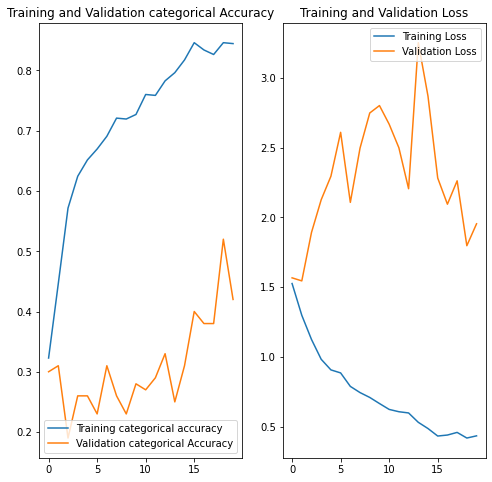

In [ ]:
acc = history_5.history['categorical_accuracy']
val_acc = history_5.history['val_categorical_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training categorical accuracy')
plt.plot(epochs_range, val_acc, label='Validation categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We can see the above architecture has succesfully executed , and there is a boost in validation accuracy for the model. But still it's very less and our model is over fitting.

In below experiment we will use `transfer learning` for reusing the trained weights and biases from `resnet 50` , while allowing the top `10` layers of neurons to train its parameters for learing our specified purpose. We will us `time distributed` layers to distribute the images of each sequence to `individual CNN2D layer` parallaly , and finally give them as feature vectors to `RNN` followed by `softmax` dense classification layer.

### Experimentation 6

In [15]:
# from keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50

In [ ]:
base_model=ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
#we would wish to train weights of some neurons for our use case so it's better to keep some layers trainable
for layer in base_model.layers[:40]: layer.trainable = False
for layer in base_model.layers[40:]: layer.trainable = True
model_6 = Sequential()
model_6.add(TimeDistributed(base_model, input_shape=(15, 256, 256, 3)))
model_6.add(TimeDistributed(MaxPooling2D()))
# flatten
model_6.add(TimeDistributed(Flatten()))

#adding GRU/LSTM layers of more units and adding timedistributed dense layer of 128 neurons each
model_6.add(LSTM(512,return_sequences=True))
model_6.add(TimeDistributed(Dense(128, activation='relu')))
model_6.add(TimeDistributed(Dropout(0.30)))
model_6.add(Flatten())
model_6.add(Dense(64, activation='relu'))
model_6.add(Dropout(0.15))
model_6.add(Dense(5, activation='softmax'))

optimiser = 'Adam' #optimizer
model_6.compile(optimizer= optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
input_param = (None, 15, 256,256,3)
model_6.build(input_param)
print(model_6.summary())

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 15, 8, 8, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 15, 4, 4, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 15, 32768)        0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 15, 512)           68159488  
                                                                 
 time_distributed_25 (TimeDi  (None, 15, 128)          

In [ ]:
batch_size = 32
num_epochs = 25
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#save model weights
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','--').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001) #Reducelronplateau code 
callbacks_list = [checkpoint, LR]


#steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history_6=model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/25


ResourceExhaustedError: ignored

#### We saw in above experimentation we got an out of memory exception , which might be caused by choosing a higher batch size , let's lessen the batch size to 20.

### Experimentation 7

In [ ]:
model_7 = Sequential()
model_7.add(TimeDistributed(base_model, input_shape=(15, 256, 256, 3)))
model_7.add(TimeDistributed(MaxPooling2D()))
# flatten
model_7.add(TimeDistributed(Flatten()))

#adding GRU/LSTM layers of more units and adding timedistributed dense layer of 128 neurons each
model_7.add(LSTM(512,return_sequences=True))
model_7.add(TimeDistributed(Dense(128, activation='relu')))
model_7.add(TimeDistributed(Dropout(0.30)))
model_7.add(Flatten())
model_7.add(Dense(64, activation='relu'))
model_7.add(Dropout(0.15))
model_7.add(Dense(5, activation='softmax'))

optimiser = 'Adam' #optimizer
model_7.compile(optimizer= optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
input_param = (None, 15, 256,256,3)
model_7.build(input_param)
print(model_7.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, 15, 8, 8, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 15, 4, 4, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 32768)        0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 15, 512)           68159488  
                                                                 
 time_distributed_30 (TimeDi  (None, 15, 128)          65664     
 stributed)                                           

In [ ]:
batch_size = 10
num_epochs = 25
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#save model weights
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','--').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001) #Reducelronplateau code 
callbacks_list = [checkpoint, LR]


#steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history_7=model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.6818 - categorical_accuracy: 0.1916Source path =  /content/Project_data/val ; batch size = 10

Epoch 1: saving model to model_init_2022-05-13--12_25_07.267269/model-00001-1.68181-0.19155-1.62503-0.21000.h5
67/67 [==============================] - 198s 3s/step - loss: 1.6818 - categorical_accuracy: 0.1916 - val_loss: 1.6250 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.6193 - categorical_accuracy: 0.2021
Epoch 2: saving model to model_init_2022-05-13--12_25_07.267269/model-00002-1.61935-0.20211-1.60909-0.22000.h5
67/67 [==============================] - 189s 3s/step - loss: 1.6193 - categorical_accuracy: 0.2021 - val_loss: 1.6091 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.6143 - categorical_accuracy: 0.1961
Epoch 

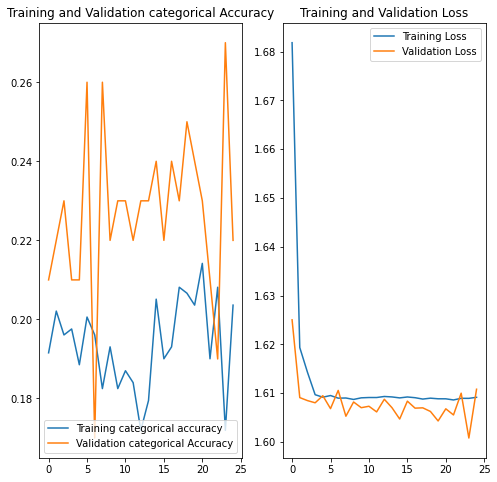

In [ ]:
acc = history_7.history['categorical_accuracy']
val_acc = history_7.history['val_categorical_accuracy']

loss = history_7.history['loss']
val_loss = history_7.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training categorical accuracy')
plt.plot(epochs_range, val_acc, label='Validation categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We can see by reducing the batch size to 10 we are getting significantly lower training accuracy and validation accuracy too hence we need a way to give higher batch size with out exhausting the graphics memory , which can be possible only if we reduce the image size while resizing .

#### Below is a re-written generator which which resizes image to even lower diamension

In [4]:
def generator_mod(source_path, folder_list, batch_size, scale_f=70):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    img_idx = [i for i in range(0,30,2)]
  
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches = int(len(folder_list)/batch_size)
    
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),scale_f,scale_f,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #We have 160*120 and 360*360 images, we will resize every image to scale_f*scale_f
                    image = transform.resize(image, (scale_f, scale_f))
                    
                    
                    #normalising using min-max method
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - np.min(image[:,:,0])/np.max(image[:,:,0]) - np.min(image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - np.min(image[:,:,1])/np.max(image[:,:,1]) - np.min(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - np.min(image[:,:,2])/np.max(image[:,:,2]) - np.min(image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        
        left_samples = len(folder_list)%batch_size
        offset = len(folder_list) - left_samples
        if (left_samples > 0):
            batch_data = np.zeros((left_samples,len(img_idx),scale_f,scale_f,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((left_samples,5)) # batch_labels is the one hot representation of the output
            for folder in range(left_samples): # iterate over the left_samples
                imgs = os.listdir(source_path+'/'+ t[folder + offset].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + offset].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    #We have 160*120 and 360*360 images, we will resize every image to scale_f*scale_f
                    image = transform.resize(image, (scale_f, scale_f))


                    #normalising using min-max method
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - np.min(image[:,:,0])/np.max(image[:,:,0]) - np.min(image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - np.min(image[:,:,1])/np.max(image[:,:,1]) - np.min(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - np.min(image[:,:,2])/np.max(image[:,:,2]) - np.min(image[:,:,2])#normalise and feed in the image

                batch_labels[folder, int(t[folder + offset].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

#### In the following model we will use above generator function and observe whether the accuracy goes up for validation data.

#### EXPERIMENT 8

In [17]:
base_model=ResNet50(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
#we would wish to train weights of some neurons for our use case so it's better to keep some layers trainable
for layer in base_model.layers[:40]: layer.trainable = False
for layer in base_model.layers[40:]: layer.trainable = True
model_8 = Sequential()
model_8.add(TimeDistributed(base_model, input_shape=(15, 75, 75, 3)))
model_8.add(TimeDistributed(MaxPooling2D()))
# flatten
model_8.add(TimeDistributed(Flatten()))

#adding GRU/LSTM layers of more units and adding timedistributed dense layer of 128 neurons each
model_8.add(LSTM(512,return_sequences=True))
model_8.add(TimeDistributed(Dense(128, activation='relu')))
model_8.add(TimeDistributed(Dropout(0.30)))
model_8.add(Flatten())
model_8.add(Dense(64, activation='relu'))
model_8.add(Dropout(0.15))
model_8.add(Dense(5, activation='softmax'))

optimiser = 'Adam' #optimizer
model_8.compile(optimizer= optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
input_param = (None, 15, 75,75,3)
model_8.build(input_param)
print(model_8.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1, 1, 2048)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 15, 512)           5244928   
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 128)          65664     
 tributed)                                            

In [18]:
batch_size = 20
num_epochs = 25
train_generator = generator_mod(train_path, train_doc, batch_size, scale_f=75)
val_generator = generator_mod(val_path, val_doc, batch_size, scale_f=75)

#save model weights
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','--').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0005) #Reducelronplateau code 
callbacks_list = [checkpoint, LR]


#steps per epoch
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
history_8=model_8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.3400 - categorical_accuracy: 0.4208Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-05-14--06_26_28.777725/model-00001-1.34000-0.42081-1.23627-0.43000.h5
34/34 [==============================] - 122s 3s/step - loss: 1.3400 - categorical_accuracy: 0.4208 - val_loss: 1.2363 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.9091 - categorical_accuracy: 0.6682
Epoch 2: saving model to model_init_2022-05-14--06_26_28.777725/model-00002-0.90912-0.66817-1.47317-0.53000.h5
34/34 [==============================] - 92s 3s/step - loss: 0.9091 - categorical_accuracy: 0.6682 - val_loss: 1.4732 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.6802 - categorical_accuracy: 0.7557
Epoch 3

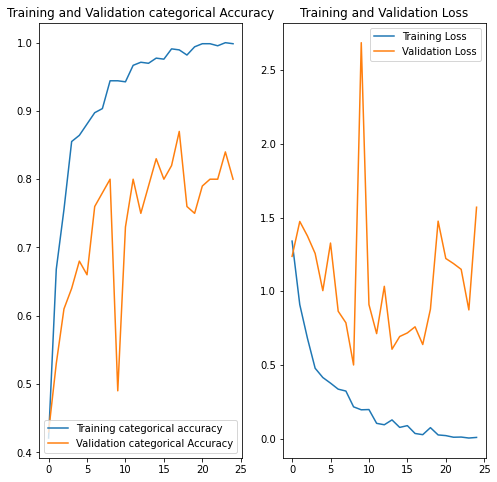

In [20]:
acc = history_8.history['categorical_accuracy']
val_acc = history_8.history['val_categorical_accuracy']

loss = history_8.history['loss']
val_loss = history_8.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training categorical accuracy')
plt.plot(epochs_range, val_acc, label='Validation categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### So , as we can see the validation accuracy is qite high in the above experiment ,the best validation accurracy we got in the 18 epoch with categorical_accuracy: 0.9894 val_categorical_accuracy: 0.8700

### That would be end of our experiments as of now.